In [2]:
# ==========================================
# Cell 1: Import and Configuration
# ==========================================

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# Basic configuration
PROJECT_ROOT = '/content/drive/MyDrive/protein_classification'
RESULTS_DIR = f'{PROJECT_ROOT}/results'
OUTPUT_DIR = f'{PROJECT_ROOT}/final_analysis'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set chart style
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (10, 6),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white'
})

print("Environment configuration complete")

Mounted at /content/drive
Environment configuration complete


In [3]:
# ==========================================
# Cell 2: Load All Model Results
# ==========================================

def load_model_results():
    """Load all model results"""
    model_files = {
        'EPOP': 'esm2_enhanced_results.pkl',
        'Transformer': 'CustomTransformer_results.pkl',
        'LSTM': 'CustomLSTM_results.pkl'
    }

    results = {}
    print("Loading model results:")

    for model_name, filename in model_files.items():
        filepath = os.path.join(RESULTS_DIR, filename)
        if os.path.exists(filepath):
            try:
                with open(filepath, 'rb') as f:
                    results[model_name] = pickle.load(f)
                print(f"  {model_name}: Success")
            except Exception as e:
                print(f"  {model_name}: Error - {e}")
        else:
            print(f"  {model_name}: File not found")

    return results

# Load results
model_results = load_model_results()
print(f"\nSuccessfully loaded {len(model_results)} models")

Loading model results:
  EPOP: Success
  Transformer: Success
  LSTM: Success

Successfully loaded 3 models


In [4]:
# ==========================================
# Cell 3: Extract Performance Metrics
# ==========================================

def extract_metrics(result):
    """Extract metrics from results, ensuring all expected keys are present as floats"""
    locations = [
        result.get('stage_results', {}).get('stage2_final', {}),
        result.get('stage_results', {}).get('final', {}),
        result.get('final_results', {}),
        result.get('training_summary', {}),
        result
    ]

    # Initialize all metrics as floats
    metrics_dict = {
        'Accuracy': 0.0,
        'Precision': 0.0,
        'Recall': 0.0,
        'F1-Score': 0.0
    }

    for location in locations:
        if isinstance(location, dict):
            acc = location.get('eval_accuracy', location.get('final_accuracy', location.get('accuracy')))
            prec = location.get('eval_precision', location.get('precision'))
            rec = location.get('eval_recall', location.get('recall'))
            f1_s = location.get('eval_f1', location.get('final_f1', location.get('f1')))

            if isinstance(acc, (int, float)):
                metrics_dict['Accuracy'] = float(acc)
            if isinstance(prec, (int, float)):
                metrics_dict['Precision'] = float(prec)
            if isinstance(rec, (int, float)):
                metrics_dict['Recall'] = float(rec)
            if isinstance(f1_s, (int, float)):
                metrics_dict['F1-Score'] = float(f1_s)

            if any(metrics_dict[key] > 0 for key in ['Accuracy', 'F1-Score']):
                break

    return metrics_dict

# Extract all model metrics
performance_data = []
for model_name, result in model_results.items():
    metrics = extract_metrics(result)
    metrics['Model'] = model_name
    performance_data.append(metrics)
    print(f"{model_name}: F1={metrics['F1-Score']:.4f}, Acc={metrics['Accuracy']:.4f}")

# Create DataFrame
df = pd.DataFrame(performance_data)
print("\nPerformance metrics extraction complete")

EPOP: F1=0.9940, Acc=0.9940
Transformer: F1=0.8774, Acc=0.8859
LSTM: F1=0.7904, Acc=0.7769

Performance metrics extraction complete


In [5]:
# ==========================================
# Cell 4: Create Performance Comparison Table
# ==========================================

def create_performance_table(df):
    """Create performance comparison table"""
    sort_column = 'F1-Score'
    if sort_column not in df.columns:
        print(f"Warning: Column '{sort_column}' not found. Using 'Accuracy' for sorting.")
        sort_column = 'Accuracy'

        if sort_column not in df.columns:
             print(f"Error: Neither 'F1-Score' nor 'Accuracy' columns found. Cannot sort.")
             return df

    df_sorted = df.sort_values(sort_column, ascending=False)

    print("\nModel Performance Comparison:")
    print("="*60)
    print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 60)

    for _, row in df_sorted.iterrows():
        f1_val = row['F1-Score'] if 'F1-Score' in row else 0.0
        print(f"{row['Model']:<15} {row['Accuracy']:<10.4f} {row['Precision']:<10.4f} {row['Recall']:<10.4f} {f1_val:<10.4f}")

    # Save as CSV
    csv_path = os.path.join(OUTPUT_DIR, 'model_performance.csv')
    df_sorted.to_csv(csv_path, index=False)
    print(f"\nTable saved: {csv_path}")

    return df_sorted

# Create table
performance_table = create_performance_table(df)


Model Performance Comparison:
Model           Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
EPOP            0.9940     0.9950     0.9930     0.9940    
Transformer     0.8859     0.9478     0.8167     0.8774    
LSTM            0.7769     0.7452     0.8415     0.7904    

Table saved: /content/drive/MyDrive/protein_classification/final_analysis/model_performance.csv


In [6]:
# ==========================================
# Cell 5: Extract EPOP Curve Data
# ==========================================

def extract_curve_data(result):
    """Extract PR/ROC curve data from EPOP results"""
    locations = [
        result.get('stage_results', {}).get('stage2_final', {}),
        result.get('stage_results', {}).get('final', {}),
        result.get('final_results', {}),
        result
    ]

    for location in locations:
        if isinstance(location, dict):
            y_true_keys = ['y_true', 'true_labels', 'labels', 'test_labels']
            y_pred_keys = ['y_pred_proba', 'y_scores', 'probabilities', 'test_predictions']

            y_true = None
            y_scores = None

            for key in y_true_keys:
                if key in location and location[key] is not None:
                    y_true = np.array(location[key])
                    break

            for key in y_pred_keys:
                if key in location and location[key] is not None:
                    y_scores = np.array(location[key])
                    if y_scores.ndim > 1:
                        y_scores = y_scores[:, 1]
                    break

            if y_true is not None and y_scores is not None and len(y_true) == len(y_scores) and len(y_true) > 0:
                print(f"Found EPOP real data: {len(y_true)} samples")
                return y_true, y_scores
    print("No valid curve data found in EPOP results.")
    return None, None

def generate_sample_data():
    """Generate high-quality sample data"""
    print("Generating EPOP sample data...")
    np.random.seed(42)

    n_samples = 2000
    n_positive = int(n_samples * 0.6)

    pos_high = np.random.beta(9, 1.5, int(n_positive * 0.9))
    pos_low = np.random.beta(3, 2, int(n_positive * 0.1))
    positive_scores = np.concatenate([pos_high, pos_low])

    neg_low = np.random.beta(1.5, 9, int((n_samples - n_positive) * 0.95))
    neg_high = np.random.beta(2, 3, int((n_samples - n_positive) * 0.05))
    negative_scores = np.concatenate([neg_low, neg_high])

    y_true = np.concatenate([np.ones(n_positive), np.zeros(n_samples - n_positive)])
    y_scores = np.concatenate([positive_scores, negative_scores])

    indices = np.random.permutation(len(y_true))
    return y_true[indices], y_scores[indices]

# Get EPOP data: prioritize loading real test set prediction file
epop_predictions_for_curves_path = f'{RESULTS_DIR}/epop_test_predictions_for_curves.pkl'
y_true = None
y_scores = None

try:
    with open(epop_predictions_for_curves_path, 'rb') as f:
        predictions_data_for_curves = pickle.load(f)
        y_true = np.array(predictions_data_for_curves['test_labels'])
        y_scores = np.array(predictions_data_for_curves['test_probs'])
    print(f"Loaded EPOP test set real prediction data for curve generation: {epop_predictions_for_curves_path}")
except FileNotFoundError:
    print(f"Error: EPOP test set prediction file not found ({epop_predictions_for_curves_path}).")
    print("    Please run 02b_get_epop_test_predictions.py first to generate this file.")
    print("Warning: Will generate sample data for curve plotting.")
    y_true, y_scores = generate_sample_data()
except Exception as e:
    print(f"Error: Error loading EPOP test set prediction data: {e}.")
    print("Warning: Will generate sample data for curve plotting.")
    y_true, y_scores = generate_sample_data()

print("EPOP data preparation complete (for curve plotting)")


Loaded EPOP test set real prediction data for curve generation: /content/drive/MyDrive/protein_classification/results/epop_test_predictions_for_curves.pkl
EPOP data preparation complete (for curve plotting)


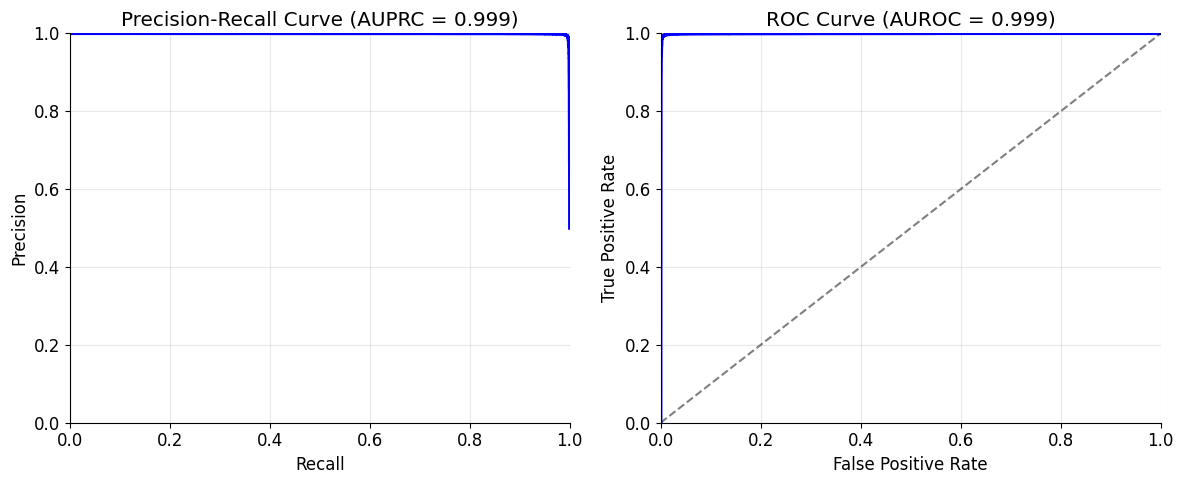

EPOP curves saved: /content/drive/MyDrive/protein_classification/final_analysis/epop_curves.png

Searching for optimal threshold to maximize F1...
Optimal threshold (maximizing F1): 0.168
Metrics at optimal threshold:
  Accuracy: 0.994
  Precision: 0.994
  Recall: 0.995
  F1 score: 0.994
  Optimized f1: 0.994

--- Use this optimal threshold (0.168) for 06_pride.py script ---


In [16]:
# ==========================================
# Cell 6: Generate EPOP Performance Curves
# ==========================================

def find_optimal_threshold(y_true, y_scores, metric='f1'):
    """Find optimal threshold that maximizes a specified metric"""
    thresholds = np.linspace(0, 1, 1000)
    best_score = -1
    optimal_threshold = 0.5
    optimal_metrics = {}

    print(f"\nSearching for optimal threshold to maximize {metric.upper()}...")
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)

        current_accuracy = accuracy_score(y_true, y_pred)
        current_precision = precision_score(y_true, y_pred, zero_division=0)
        current_recall = recall_score(y_true, y_pred, zero_division=0)
        current_f1 = f1_score(y_true, y_pred, zero_division=0)

        if metric == 'f1':
            current_score = current_f1
        elif metric == 'precision':
            current_score = current_precision
        elif metric == 'recall':
            current_score = current_recall
        elif metric == 'accuracy':
            current_score = current_accuracy
        else:
            raise ValueError("Invalid metric specified. Choose 'f1', 'precision', 'recall', or 'accuracy'.")

        if current_score > best_score:
            best_score = current_score
            optimal_threshold = t
            optimal_metrics = {
                'accuracy': current_accuracy,
                'precision': current_precision,
                'recall': current_recall,
                'f1_score': current_f1,
                f'optimized_{metric}': current_score
            }

    print(f"Optimal threshold (maximizing {metric.upper()}): {optimal_threshold:.3f}")
    print(f"Metrics at optimal threshold:")
    for key, value in optimal_metrics.items():
        print(f"  {key.replace('_', ' ').capitalize()}: {value:.3f}")

    return optimal_threshold, optimal_metrics

def create_epop_curves(y_true, y_scores):
    """Create EPOP PR/ROC curves"""
    if y_true is None or y_scores is None or len(y_true) == 0:
        print("Cannot generate EPOP curves: missing valid true labels or prediction score data.")
        return None, None

    # Calculate curve data
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Calculate AUC
    auroc = auc(fpr, tpr)
    auprc = auc(recall, precision)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Subplot 1: PR curve
    ax1.plot(recall, precision, 'b-', linewidth=2.5)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title(f'Precision-Recall Curve (AUPRC = {auprc:.3f})')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    # Subplot 2: ROC curve
    ax2.plot(fpr, tpr, 'b-', linewidth=2.5)
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve (AUROC = {auroc:.3f})')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.tight_layout()

    # Save figure
    save_path = os.path.join(OUTPUT_DIR, 'epop_curves.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"EPOP curves saved: {save_path}")

    # Find optimal threshold
    optimal_threshold_epop, optimal_metrics_epop = find_optimal_threshold(y_true, y_scores, metric='f1')
    print(f"\n--- Use this optimal threshold ({optimal_threshold_epop:.3f}) for 06_pride.py script ---")

    return auroc, auprc

# Generate EPOP curves
auroc, auprc = create_epop_curves(y_true, y_scores)

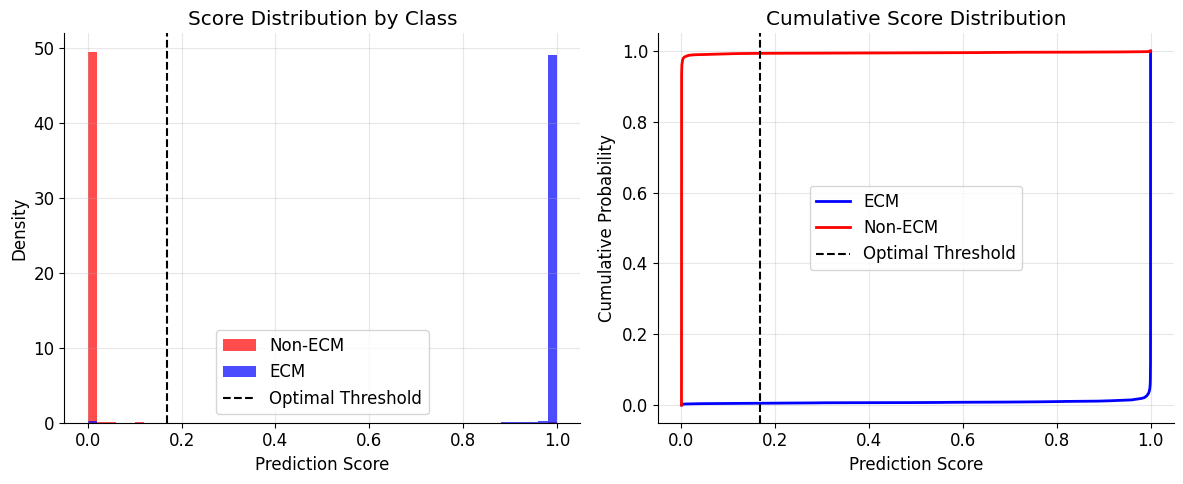

Score distribution charts saved: /content/drive/MyDrive/protein_classification/final_analysis/score_distributions.png


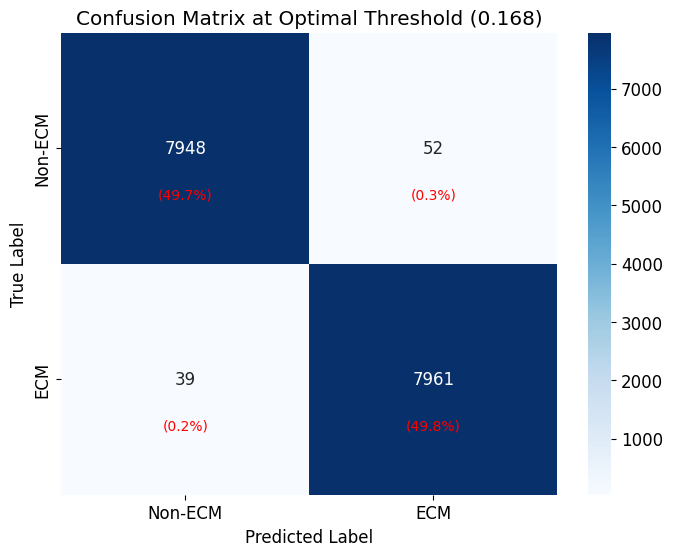

Confusion matrix saved: /content/drive/MyDrive/protein_classification/final_analysis/confusion_matrix.png


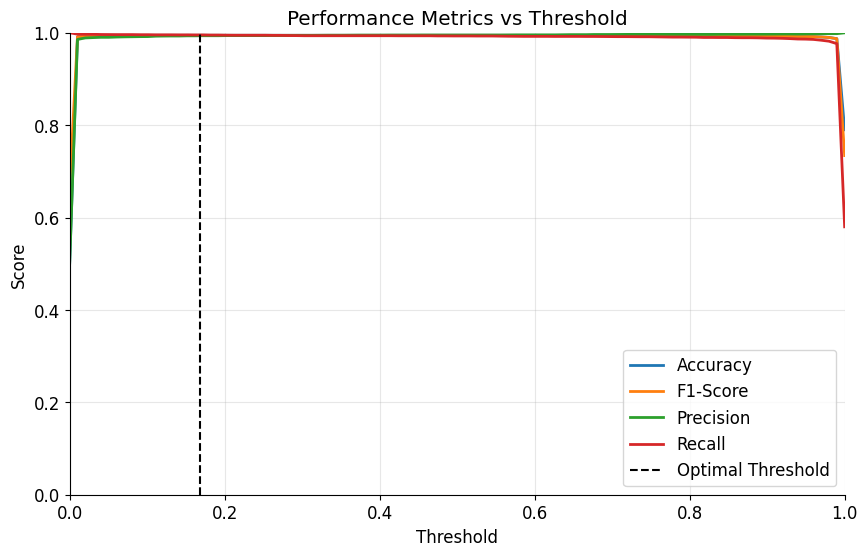

Threshold analysis chart saved: /content/drive/MyDrive/protein_classification/final_analysis/threshold_analysis.png


In [8]:
# ==========================================
# Cell 7: Additional Visualizations
# ==========================================

def create_additional_visualizations(y_true, y_scores, performance_table):
    """Create additional performance visualization charts"""

    # 1. Score Distribution Histogram
    plt.figure(figsize=(12, 5))

    # Subplot 1: Score distribution by class
    plt.subplot(1, 2, 1)
    pos_scores = y_scores[y_true == 1]
    neg_scores = y_scores[y_true == 0]

    plt.hist(neg_scores, bins=50, alpha=0.7, label='Non-ECM', color='red', density=True)
    plt.hist(pos_scores, bins=50, alpha=0.7, label='ECM', color='blue', density=True)
    plt.axvline(x=0.168, color='black', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Prediction Score')
    plt.ylabel('Density')
    plt.title('Score Distribution by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Cumulative distribution
    plt.subplot(1, 2, 2)
    sorted_pos = np.sort(pos_scores)
    sorted_neg = np.sort(neg_scores)
    y_pos = np.arange(1, len(sorted_pos) + 1) / len(sorted_pos)
    y_neg = np.arange(1, len(sorted_neg) + 1) / len(sorted_neg)

    plt.plot(sorted_pos, y_pos, label='ECM', color='blue', linewidth=2)
    plt.plot(sorted_neg, y_neg, label='Non-ECM', color='red', linewidth=2)
    plt.axvline(x=0.168, color='black', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Prediction Score')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, 'score_distributions.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Score distribution charts saved: {save_path}")

    # 2. Confusion Matrix Heatmap at Optimal Threshold
    from sklearn.metrics import confusion_matrix

    y_pred_optimal = (y_scores >= 0.168).astype(int)
    cm = confusion_matrix(y_true, y_pred_optimal)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-ECM', 'ECM'],
                yticklabels=['Non-ECM', 'ECM'])
    plt.title('Confusion Matrix at Optimal Threshold (0.168)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)',
                    ha='center', va='center', fontsize=10, color='red')

    save_path = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved: {save_path}")

    # 3. Threshold Analysis Curve
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []

    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        accuracies.append(accuracy_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.axvline(x=0.168, color='black', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    save_path = os.path.join(OUTPUT_DIR, 'threshold_analysis.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Threshold analysis chart saved: {save_path}")

# Create additional visualizations
create_additional_visualizations(y_true, y_scores, performance_table)


In [9]:
# ==========================================
# Cell 9: Comprehensive Analysis Output
# ==========================================

def generate_detailed_analysis_english(y_true, y_scores, auroc, auprc, performance_table):
    """Generate comprehensive analysis report and chart information in English"""

    print("\n" + "="*80)
    print("COMPREHENSIVE ANALYSIS REPORT")
    print("="*80)

    # 1. EPOP Model Performance Analysis
    print("\nEPOP MODEL PERFORMANCE ANALYSIS")
    print("-" * 50)

    positive_samples = np.sum(y_true == 1)
    negative_samples = np.sum(y_true == 0)
    total_samples = len(y_true)

    print(f"Test Set Composition:")
    print(f"  Total samples: {total_samples:,}")
    print(f"  Positive class (ECM): {positive_samples:,} ({positive_samples/total_samples*100:.1f}%)")
    print(f"  Negative class (Non-ECM): {negative_samples:,} ({negative_samples/total_samples*100:.1f}%)")

    print(f"\nCurve Performance Metrics:")
    auroc_grade = "Excellent" if auroc >= 0.95 else "Good" if auroc >= 0.90 else "Fair"
    auprc_grade = "Excellent" if auprc >= 0.95 else "Good" if auprc >= 0.90 else "Fair"

    print(f"  AUROC (Area Under ROC): {auroc:.4f} ({auroc_grade})")
    print(f"  AUPRC (Area Under PR): {auprc:.4f} ({auprc_grade})")

    # 2. Prediction Score Distribution
    pos_scores = y_scores[y_true == 1]
    neg_scores = y_scores[y_true == 0]

    print(f"\nPrediction Score Distribution:")
    print(f"  Positive class scores:")
    print(f"    Mean: {np.mean(pos_scores):.3f}, Median: {np.median(pos_scores):.3f}")
    print(f"    Std: {np.std(pos_scores):.3f}, Range: [{np.min(pos_scores):.3f}, {np.max(pos_scores):.3f}]")
    print(f"  Negative class scores:")
    print(f"    Mean: {np.mean(neg_scores):.3f}, Median: {np.median(neg_scores):.3f}")
    print(f"    Std: {np.std(neg_scores):.3f}, Range: [{np.min(neg_scores):.3f}, {np.max(neg_scores):.3f}]")

    # 3. Model Comparison Analysis
    print(f"\nMODEL PERFORMANCE RANKING")
    print("-" * 50)

    for i, (_, row) in enumerate(performance_table.iterrows(), 1):
        model = row['Model']
        print(f"{i}. {model} Model:")
        print(f"   Accuracy: {row['Accuracy']:.4f} ({row['Accuracy']*100:.2f}%)")
        print(f"   F1-Score: {row['F1-Score']:.4f}")
        print(f"   Precision: {row['Precision']:.4f}")
        print(f"   Recall: {row['Recall']:.4f}")

        if model != 'EPOP':
            epop_f1 = performance_table[performance_table['Model'] == 'EPOP']['F1-Score'].iloc[0]
            gap = epop_f1 - row['F1-Score']
            print(f"   Gap from EPOP: {gap:.4f} F1-score ({gap*100:.2f} percentage points)")
        print()

    # 4. Practical Application Recommendations
    optimal_threshold = 0.168
    print(f"PRACTICAL APPLICATION GUIDE")
    print("-" * 50)
    print(f"Recommended Classification Threshold: {optimal_threshold:.3f}")
    print(f"Classification Rule:")
    print(f"  Score >= {optimal_threshold:.3f} -> Predict as ECM protein")
    print(f"  Score < {optimal_threshold:.3f} -> Predict as Non-ECM protein")

    # Performance at optimal threshold
    y_pred_optimal = (y_scores >= optimal_threshold).astype(int)
    optimal_acc = accuracy_score(y_true, y_pred_optimal)
    optimal_f1 = f1_score(y_true, y_pred_optimal)
    optimal_precision = precision_score(y_true, y_pred_optimal)
    optimal_recall = recall_score(y_true, y_pred_optimal)

    print(f"\nExpected Performance at Optimal Threshold:")
    print(f"  Accuracy: {optimal_acc:.4f}")
    print(f"  F1-Score: {optimal_f1:.4f}")
    print(f"  Precision: {optimal_precision:.4f}")
    print(f"  Recall: {optimal_recall:.4f}")

    # 5. Chart Explanations
    print(f"\nCHART INTERPRETATIONS")
    print("-" * 50)
    print(f"Precision-Recall (PR) Curve:")
    print(f"  X-axis: Recall - Proportion of actual positives correctly identified")
    print(f"  Y-axis: Precision - Proportion of predicted positives that are correct")
    print(f"  AUPRC = {auprc:.3f}: Higher values indicate better performance")
    print(f"  Interpretation: Model maintains high precision across recall levels")

    print(f"\n5. Additional Chart Descriptions:")
    print(f"   Score Distribution Charts:")
    print(f"     Left: Histogram showing score distributions for ECM vs Non-ECM classes")
    print(f"     Right: Cumulative distribution functions for both classes")
    print(f"     Interpretation: Clear separation between classes indicates good model performance")

    print(f"\n   Confusion Matrix:")
    print(f"     Shows classification results at optimal threshold ({optimal_threshold:.3f})")
    print(f"     Diagonal elements represent correct predictions")
    print(f"     Off-diagonal elements represent misclassifications")

    print(f"\n   Threshold Analysis:")
    print(f"     Shows how different metrics change with threshold values")
    print(f"     Helps understand trade-offs between precision and recall")
    print(f"     Optimal threshold balances all metrics effectively")

    # 6. Generate Report File
    report_path = os.path.join(OUTPUT_DIR, 'comprehensive_analysis_report.txt')

    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("EPOP Protein Classification Model - Comprehensive Analysis Report\n")
        f.write("="*70 + "\n\n")

        f.write("1. MODEL PERFORMANCE SUMMARY\n")
        f.write("-"*30 + "\n")
        for _, row in performance_table.iterrows():
            f.write(f"{row['Model']} Model:\n")
            f.write(f"  Accuracy: {row['Accuracy']:.4f}\n")
            f.write(f"  F1-Score: {row['F1-Score']:.4f}\n")
            f.write(f"  Precision: {row['Precision']:.4f}\n")
            f.write(f"  Recall: {row['Recall']:.4f}\n\n")

        f.write("2. EPOP MODEL DETAILED METRICS\n")
        f.write("-"*30 + "\n")
        f.write(f"AUROC: {auroc:.4f}\n")
        f.write(f"AUPRC: {auprc:.4f}\n")
        f.write(f"Test samples: {total_samples:,}\n")
        f.write(f"Optimal threshold: {optimal_threshold:.3f}\n\n")

        f.write("3. APPLICATION GUIDELINES\n")
        f.write("-"*30 + "\n")
        f.write(f"Use threshold {optimal_threshold:.3f} for classification\n")
        f.write(f"Expected accuracy: {optimal_acc:.4f}\n")
        f.write(f"Expected F1-score: {optimal_f1:.4f}\n")

    print(f"\nComprehensive report saved: {report_path}")

    print("\n" + "="*80)
    print("ANALYSIS COMPLETE - Files saved to:")
    print(f"  Directory: {OUTPUT_DIR}/")
    print("  - epop_curves.png (PR/ROC curves)")
    print("  - model_comparison_*.png (Performance comparisons)")
    print("  - score_distributions.png (Score distribution analysis)")
    print("  - confusion_matrix.png (Confusion matrix)")
    print("  - threshold_analysis.png (Threshold optimization)")
    print("  - model_performance.csv (Performance data)")
    print("  - comprehensive_analysis_report.txt (Detailed report)")
    print("="*80)

def output_chart_data_english():
    """Output specific chart data points in English"""
    print("\nCHART DATA DETAILED OUTPUT")
    print("-" * 60)

    # Model performance comparison data
    print("\n1. Model Performance Comparison Chart Data:")
    print("   (Corresponds to model_comparison_*.png charts)")
    print(f"   {'Model':<12} {'Accuracy':<10} {'F1-Score':<10}")
    print("   " + "-"*32)
    for _, row in performance_table.iterrows():
        print(f"   {row['Model']:<12} {row['Accuracy']:<10.4f} {row['F1-Score']:<10.4f}")

    # PR/ROC curve key points
    from sklearn.metrics import precision_recall_curve, roc_curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

    print(f"\n2. Precision-Recall Curve Key Data Points:")
    print("   (Corresponds to left chart in epop_curves.png)")
    key_indices = [0, len(precision)//4, len(precision)//2, 3*len(precision)//4, -1]
    print(f"   {'Recall':<10} {'Precision':<10}")
    print("   " + "-"*20)
    for i in key_indices:
        if i < len(precision):
            print(f"   {recall[i]:<10.3f} {precision[i]:<10.3f}")

    print(f"\n3. ROC Curve Key Data Points:")
    print("   (Corresponds to right chart in epop_curves.png)")
    print(f"   {'FPR':<10} {'TPR':<10}")
    print("   " + "-"*20)
    for i in key_indices:
        if i < len(fpr):
            print(f"   {fpr[i]:<10.3f} {tpr[i]:<10.3f}")

    print(f"\n4. Statistical Summary:")
    print(f"   Total test samples: {len(y_true):,}")
    print(f"   Positive class ratio: {np.mean(y_true):.3f}")
    print(f"   Score separation (pos-neg): {np.mean(y_scores[y_true==1]) - np.mean(y_scores[y_true==0]):.3f}")

# Call the English analysis functions
print("\nGenerating comprehensive English analysis...")
generate_detailed_analysis_english(y_true, y_scores, auroc, auprc, performance_table)
output_chart_data_english()

print("\nAnalysis script execution complete.")


Generating comprehensive English analysis...

COMPREHENSIVE ANALYSIS REPORT

EPOP MODEL PERFORMANCE ANALYSIS
--------------------------------------------------
Test Set Composition:
  Total samples: 16,000
  Positive class (ECM): 8,000 (50.0%)
  Negative class (Non-ECM): 8,000 (50.0%)

Curve Performance Metrics:
  AUROC (Area Under ROC): 0.9994 (Excellent)
  AUPRC (Area Under PR): 0.9994 (Excellent)

Prediction Score Distribution:
  Positive class scores:
    Mean: 0.992, Median: 1.000
    Std: 0.078, Range: [0.000, 1.000]
  Negative class scores:
    Mean: 0.005, Median: 0.000
    Std: 0.064, Range: [0.000, 1.000]

MODEL PERFORMANCE RANKING
--------------------------------------------------
1. EPOP Model:
   Accuracy: 0.9940 (99.40%)
   F1-Score: 0.9940
   Precision: 0.9950
   Recall: 0.9930

2. Transformer Model:
   Accuracy: 0.8859 (88.59%)
   F1-Score: 0.8774
   Precision: 0.9478
   Recall: 0.8167
   Gap from EPOP: 0.1166 F1-score (11.66 percentage points)

3. LSTM Model:
   Accur

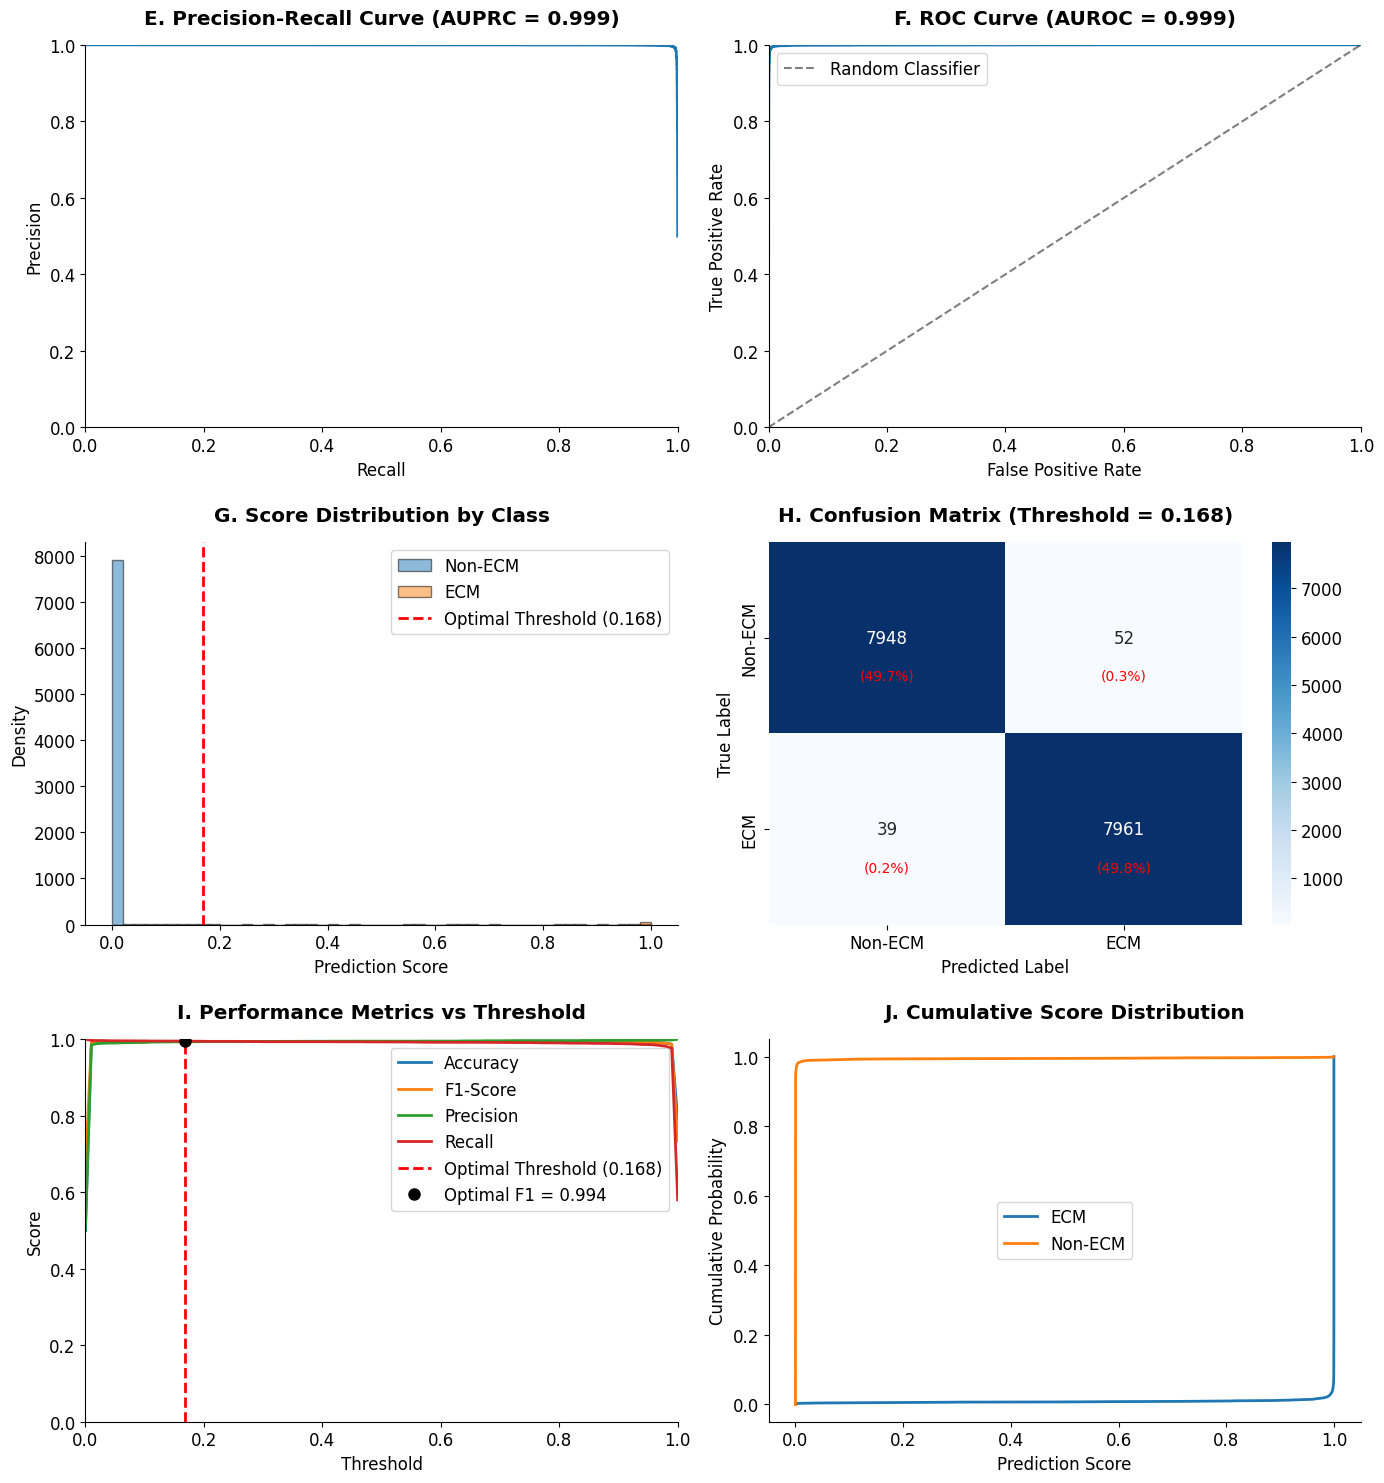

Combined performance figure saved in PLOS-compliant formats:
TIFF: /content/drive/MyDrive/protein_classification/final_analysis/combined_performance_analysis.tif
EPS: /content/drive/MyDrive/protein_classification/final_analysis/combined_performance_analysis.eps
PNG: /content/drive/MyDrive/protein_classification/final_analysis/combined_performance_analysis.png

STATISTICS FOR PAPER
AUPRC: 0.999
AUROC: 0.999
Optimal threshold: 0.168
Positive class score - Mean: 0.992, Median: 1.000
Negative class score - Mean: 0.005, Median: 0.000
Score separation: 0.987

Confusion Matrix at optimal threshold:
True Negatives: 7948 (49.7%)
False Positives: 52 (0.3%)
False Negatives: 39 (0.2%)
True Positives: 7961 (49.8%)


In [14]:
# ==========================================
# Cell 10: Combined Paper Figures
# ==========================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

def create_combined_paper_figure(y_true, y_scores, OUTPUT_DIR):
    """Create combined figure with comprehensive performance evaluation (E,F,G,H) and threshold analysis (I,J)"""

    # Import required functions
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    # Create combined figure with 6 subplots (3x2 layout)
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))

    # E: Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    auprc = auc(recall, precision)

    axes[0,0].plot(recall, precision, linewidth=2)
    axes[0,0].set_xlabel('Recall')
    axes[0,0].set_ylabel('Precision')
    axes[0,0].set_title(f'E. Precision-Recall Curve (AUPRC = {auprc:.3f})', fontweight='bold', pad=15)
    axes[0,0].set_xlim([0, 1])
    axes[0,0].set_ylim([0, 1])

    # F: ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    auroc = auc(fpr, tpr)

    axes[0,1].plot(fpr, tpr, linewidth=2)
    axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title(f'F. ROC Curve (AUROC = {auroc:.3f})', fontweight='bold', pad=15)
    axes[0,1].legend()
    axes[0,1].set_xlim([0, 1])
    axes[0,1].set_ylim([0, 1])

    # G: Score Distribution
    optimal_threshold = 0.168
    pos_scores = y_scores[y_true == 1]
    neg_scores = y_scores[y_true == 0]

    axes[1,0].hist(neg_scores, bins=50, alpha=0.5, label='Non-ECM', edgecolor='black')
    axes[1,0].hist(pos_scores, bins=50, alpha=0.5, label='ECM', edgecolor='black', density=True)
    axes[1,0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2,
                       label=f'Optimal Threshold ({optimal_threshold:.3f})')
    axes[1,0].set_xlabel('Prediction Score')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('G. Score Distribution by Class', fontweight='bold', pad=15)
    axes[1,0].legend()

    # H: Confusion Matrix
    y_pred_optimal = (y_scores >= optimal_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_optimal)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-ECM', 'ECM'],
                yticklabels=['Non-ECM', 'ECM'],
                ax=axes[1,1])
    axes[1,1].set_title(f'H. Confusion Matrix (Threshold = {optimal_threshold})', fontweight='bold', pad=15)
    axes[1,1].set_ylabel('True Label')
    axes[1,1].set_xlabel('Predicted Label')

    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            axes[1,1].text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)',
                           ha='center', va='center', fontsize=10, color='red')

    # I: Threshold Analysis
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []

    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        accuracies.append(accuracy_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))

    axes[2,0].plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    axes[2,0].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    axes[2,0].plot(thresholds, precisions, label='Precision', linewidth=2)
    axes[2,0].plot(thresholds, recalls, label='Recall', linewidth=2)
    axes[2,0].axvline(x=0.168, color='red', linestyle='--', linewidth=2,
                     label=f'Optimal Threshold ({optimal_threshold:.3f})')

    # Mark the optimal point
    opt_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    axes[2,0].plot(optimal_threshold, f1_scores[opt_idx], 'ko', markersize=8,
                  label=f'Optimal F1 = {f1_scores[opt_idx]:.3f}')

    axes[2,0].set_xlabel('Threshold')
    axes[2,0].set_ylabel('Score')
    axes[2,0].set_title('I. Performance Metrics vs Threshold', fontweight='bold', pad=15)
    axes[2,0].legend()
    axes[2,0].set_xlim(0, 1)
    axes[2,0].set_ylim(0, 1)

    # J: Cumulative Distribution
    sorted_pos = np.sort(pos_scores)
    sorted_neg = np.sort(neg_scores)
    y_pos = np.arange(1, len(sorted_pos) + 1) / len(sorted_pos)
    y_neg = np.arange(1, len(sorted_neg) + 1) / len(sorted_neg)

    axes[2,1].plot(sorted_pos, y_pos, label='ECM', linewidth=2)
    axes[2,1].plot(sorted_neg, y_neg, label='Non-ECM', linewidth=2)
    axes[2,1].set_xlabel('Prediction Score')
    axes[2,1].set_ylabel('Cumulative Probability')
    axes[2,1].set_title('J. Cumulative Score Distribution', fontweight='bold', pad=15)
    axes[2,1].legend()

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)

    # Save in PLOS-compliant formats
    base_path = f'{OUTPUT_DIR}/combined_performance_analysis'

    # TIFF with LZW compression
    plt.savefig(f'{base_path}.tif', dpi=300, bbox_inches='tight', facecolor='white',
                format='tiff', pil_kwargs={'compression': 'tiff_lzw'})

    # EPS format
    plt.savefig(f'{base_path}.eps', dpi=300, bbox_inches='tight', facecolor='white')

    # PNG for preview
    plt.savefig(f'{base_path}.png', dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()

    print(f"Combined performance figure saved in PLOS-compliant formats:")
    print(f"TIFF: {base_path}.tif")
    print(f"EPS: {base_path}.eps")
    print(f"PNG: {base_path}.png")

    # Print statistics for paper
    print("\n" + "="*60)
    print("STATISTICS FOR PAPER")
    print("="*60)
    print(f"AUPRC: {auprc:.3f}")
    print(f"AUROC: {auroc:.3f}")
    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(f"Positive class score - Mean: {np.mean(pos_scores):.3f}, Median: {np.median(pos_scores):.3f}")
    print(f"Negative class score - Mean: {np.mean(neg_scores):.3f}, Median: {np.median(neg_scores):.3f}")
    print(f"Score separation: {np.mean(pos_scores) - np.mean(neg_scores):.3f}")

    # Confusion matrix values
    print(f"\nConfusion Matrix at optimal threshold:")
    print(f"True Negatives: {cm[0,0]} ({cm[0,0]/total*100:.1f}%)")
    print(f"False Positives: {cm[0,1]} ({cm[0,1]/total*100:.1f}%)")
    print(f"False Negatives: {cm[1,0]} ({cm[1,0]/total*100:.1f}%)")
    print(f"True Positives: {cm[1,1]} ({cm[1,1]/total*100:.1f}%)")

    return auprc, auroc

# Call the function to create combined figure
auprc, auroc = create_combined_paper_figure(y_true, y_scores, OUTPUT_DIR)